NOTEBOOK 2: IMBALANCED LEARNING (Part 1)
================================================================================
Objective: Compare 3 approaches on Source datasets:
1. Baseline XGBoost
2. SMOTE + Tomek Links + XGBoost
3. Cost-Sensitive XGBoost

Evaluation: F1-Score, Precision, Recall, AUC-ROC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, f1_score,
                             precision_score, recall_score, accuracy_score)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# XGBoost
import xgboost as xgb

# Visualization
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 5)

DATA_PATH = '../data/'

print("✅ Libraries loaded")

✅ Libraries loaded


# __Data Loading & Preprocessing :__

In [2]:
print("LOADING ALL SOURCE DATASETS ")

# Dictionary to store all datasets
datasets_processed = {}

for i in range(4):
    print(f"\n Loading Source {i}...")
    
    # Load raw data
    X_train_raw = np.load(DATA_PATH + f'kaggle_source_cate_{i}_train.npy')
    X_test_raw = np.load(DATA_PATH + f'kaggle_source_cate_{i}_test.npy')
    
    # Extract labels from FIRST column, features from remaining
    y_train_raw = X_train_raw[:, 0].astype(int)
    X_train = X_train_raw[:, 1:]
    
    y_test_raw = X_test_raw[:, 0].astype(int)
    X_test = X_test_raw[:, 1:]
    
    # Convert to BINARY (Class 2 = Fraud, Classes 0&1 = Legitimate)
    y_train = (y_train_raw == 2).astype(int)
    y_test = (y_test_raw == 2).astype(int)
    
    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Store
    datasets_processed[i] = {
        'X_train': X_train_scaled,
        'y_train': y_train,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'scaler': scaler
    }
    
    # Print stats
    counter = Counter(y_train)
    ratio = counter[0] / counter[1] if counter[1] > 0 else 0
    print(f"    Source {i}: Train {X_train.shape}, Test {X_test.shape}")
    print(f"      Class 0: {counter[0]}, Class 1: {counter[1]} (ratio: {ratio:.2f}:1)")

print("USING SOURCE 0 FOR EXPERIMENTS")

# Use Source 0 for detailed experiments
X_train_scaled = datasets_processed[0]['X_train']
y_train = datasets_processed[0]['y_train']
X_test_scaled = datasets_processed[0]['X_test']
y_test = datasets_processed[0]['y_test']

counter_train = Counter(y_train)
scale_pos_weight = counter_train[0] / counter_train[1]

print(f" Selected Source 0:")
print(f"   Train: {X_train_scaled.shape}")
print(f"   Test:  {X_test_scaled.shape}")
print(f"   Class 0: {counter_train[0]}, Class 1: {counter_train[1]}")
print(f"   Fraud %: {counter_train[1]/len(y_train)*100:.2f}%")
print(f"   scale_pos_weight: {scale_pos_weight:.2f}")

LOADING ALL SOURCE DATASETS 

 Loading Source 0...
    Source 0: Train (41058, 50), Test (13686, 50)
      Class 0: 34631, Class 1: 6427 (ratio: 5.39:1)

 Loading Source 1...
    Source 1: Train (41058, 50), Test (13686, 50)
      Class 0: 34629, Class 1: 6429 (ratio: 5.39:1)

 Loading Source 2...
    Source 2: Train (41058, 50), Test (13686, 50)
      Class 0: 34594, Class 1: 6464 (ratio: 5.35:1)

 Loading Source 3...
    Source 3: Train (41058, 50), Test (13686, 50)
      Class 0: 34593, Class 1: 6465 (ratio: 5.35:1)
USING SOURCE 0 FOR EXPERIMENTS
 Selected Source 0:
   Train: (41058, 50)
   Test:  (13686, 50)
   Class 0: 34631, Class 1: 6427
   Fraud %: 15.65%
   scale_pos_weight: 5.39


# __Baseline XGBoost Model :__

In [4]:
print("TRAINING BASELINE XGBOOST")

# Train baseline model
baseline_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_test_scaled)
y_proba_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

print("Model trained\n")

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_baseline, 
                          target_names=['Legitimate', 'Fraud'], 
                          digits=4))

# Metrics
acc = accuracy_score(y_test, y_pred_baseline)
f1 = f1_score(y_test, y_pred_baseline)
precision = precision_score(y_test, y_pred_baseline)
recall = recall_score(y_test, y_pred_baseline)
auc = roc_auc_score(y_test, y_proba_baseline)

print(f"\n Summary:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f} ")
print(f"   AUC-ROC:   {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                Legit  Fraud")
print(f"Actual Legit    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"       Fraud    {cm[1,0]:5d}  {cm[1,1]:5d}")

# Store results
results = {
    'Baseline XGBoost': {
        'accuracy': acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc,
        'y_pred': y_pred_baseline,
        'y_proba': y_proba_baseline,
        'cm': cm
    }
}

TRAINING BASELINE XGBOOST
Model trained

Classification Report:
              precision    recall  f1-score   support

  Legitimate     0.9899    0.9964    0.9932     11518
       Fraud     0.9804    0.9460    0.9629      2168

    accuracy                         0.9885     13686
   macro avg     0.9852    0.9712    0.9780     13686
weighted avg     0.9884    0.9885    0.9884     13686


 Summary:
   Accuracy:  0.9885
   F1-Score:  0.9629
   Precision: 0.9804
   Recall:    0.9460 
   AUC-ROC:   0.9989

Confusion Matrix:
                 Predicted
                Legit  Fraud
Actual Legit    11477     41
       Fraud      117   2051


In [5]:
print("TRAINING WITH SMOTE + TOMEK LINKS")

# Apply SMOTE + Tomek Links
print("Applying SMOTE + Tomek Links")
smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X_train_scaled, y_train)

print(f" Resampling completed:")
print(f"   Original:  {Counter(y_train)}")
print(f"   Resampled: {Counter(y_resampled)}")
print(f"   Shape: {X_resampled.shape}")

# Train model on resampled data
print("\nTraining XGBoost on resampled data")
smote_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

smote_model.fit(X_resampled, y_resampled)
y_pred_smote = smote_model.predict(X_test_scaled)
y_proba_smote = smote_model.predict_proba(X_test_scaled)[:, 1]

print("Model trained\n")

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_smote, 
                          target_names=['Legitimate', 'Fraud'], 
                          digits=4))

# Metrics
acc = accuracy_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
auc = roc_auc_score(y_test, y_proba_smote)

print(f"\n Summary:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   AUC-ROC:   {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_smote)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                Legit  Fraud")
print(f"Actual Legit    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"       Fraud    {cm[1,0]:5d}  {cm[1,1]:5d}")

# Store results
results['SMOTE + Tomek'] = {
    'accuracy': acc,
    'f1_score': f1,
    'precision': precision,
    'recall': recall,
    'auc_roc': auc,
    'y_pred': y_pred_smote,
    'y_proba': y_proba_smote,
    'cm': cm
}

print("\n SMOTE + Tomek completed")

TRAINING WITH SMOTE + TOMEK LINKS
Applying SMOTE + Tomek Links
 Resampling completed:
   Original:  Counter({0: 34631, 1: 6427})
   Resampled: Counter({0: 34570, 1: 34570})
   Shape: (69140, 50)

Training XGBoost on resampled data
Model trained

Classification Report:
              precision    recall  f1-score   support

  Legitimate     0.9947    0.9864    0.9905     11518
       Fraud     0.9307    0.9723    0.9510      2168

    accuracy                         0.9841     13686
   macro avg     0.9627    0.9793    0.9708     13686
weighted avg     0.9846    0.9841    0.9843     13686


 Summary:
   Accuracy:  0.9841
   F1-Score:  0.9510
   Precision: 0.9307
   Recall:    0.9723
   AUC-ROC:   0.9986

Confusion Matrix:
                 Predicted
                Legit  Fraud
Actual Legit    11361    157
       Fraud       60   2108

 SMOTE + Tomek completed


In [6]:
print("TRAINING COST-SENSITIVE XGBOOST")

print(f"Using scale_pos_weight = {scale_pos_weight:.2f}")

# Train cost-sensitive model
cost_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    eval_metric='logloss'
)

cost_model.fit(X_train_scaled, y_train)
y_pred_cost = cost_model.predict(X_test_scaled)
y_proba_cost = cost_model.predict_proba(X_test_scaled)[:, 1]

print(" Model trained\n")

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred_cost, 
                          target_names=['Legitimate', 'Fraud'], 
                          digits=4))

# Metrics
acc = accuracy_score(y_test, y_pred_cost)
f1 = f1_score(y_test, y_pred_cost)
precision = precision_score(y_test, y_pred_cost)
recall = recall_score(y_test, y_pred_cost)
auc = roc_auc_score(y_test, y_proba_cost)

print(f"\n Summary:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f} ")
print(f"   AUC-ROC:   {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cost)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                Legit  Fraud")
print(f"Actual Legit    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"       Fraud    {cm[1,0]:5d}  {cm[1,1]:5d}")

# Store results
results['Cost-Sensitive'] = {
    'accuracy': acc,
    'f1_score': f1,
    'precision': precision,
    'recall': recall,
    'auc_roc': auc,
    'y_pred': y_pred_cost,
    'y_proba': y_proba_cost,
    'cm': cm
}

print("\n Cost-Sensitive completed")

TRAINING COST-SENSITIVE XGBOOST
Using scale_pos_weight = 5.39
 Model trained

Classification Report:
              precision    recall  f1-score   support

  Legitimate     0.9976    0.9804    0.9889     11518
       Fraud     0.9045    0.9875    0.9442      2168

    accuracy                         0.9815     13686
   macro avg     0.9511    0.9840    0.9666     13686
weighted avg     0.9829    0.9815    0.9818     13686


 Summary:
   Accuracy:  0.9815
   F1-Score:  0.9442
   Precision: 0.9045
   Recall:    0.9875 
   AUC-ROC:   0.9988

Confusion Matrix:
                 Predicted
                Legit  Fraud
Actual Legit    11292    226
       Fraud       27   2141

 Cost-Sensitive completed


COMPARISON TABLE
           Model  Accuracy  F1-Score  Precision   Recall  AUC-ROC
Baseline XGBoost  0.988455  0.962911   0.980402 0.946033 0.998869
   SMOTE + Tomek  0.984144  0.951049   0.930684 0.972325 0.998635
  Cost-Sensitive  0.981514  0.944212   0.904520 0.987546 0.998843

🏆 Best Recall (fraud detection): Cost-Sensitive
🏆 Best F1-Score (balance): Baseline XGBoost


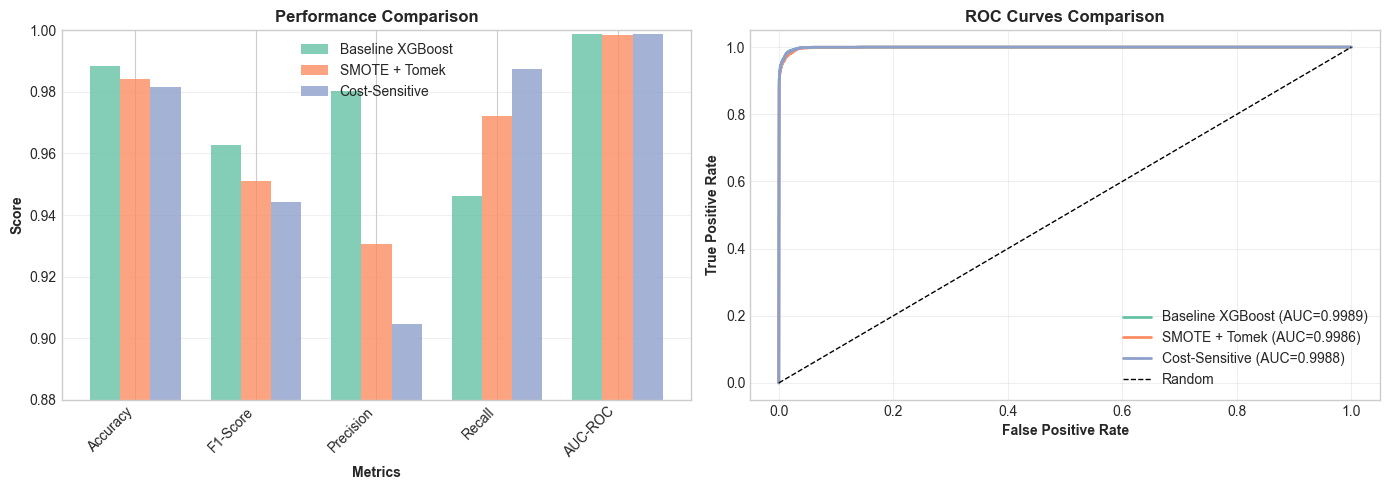


 Comparison visualization saved


In [ ]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'AUC-ROC': [results[m]['auc_roc'] for m in results]
})

print("COMPARISON TABLE")
print(comparison_df.to_string(index=False))

# Find best model
best_recall = comparison_df.loc[comparison_df['Recall'].idxmax(), 'Model']
best_f1 = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']

print(f"\n🏆 Best Recall (fraud detection): {best_recall}")
print(f"🏆 Best F1-Score (balance): {best_f1}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
ax1 = axes[0]
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'AUC-ROC']
x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(results.keys()):
    values = [comparison_df.loc[comparison_df['Model']==model, m].values[0] for m in metrics]
    ax1.bar(x + i*width, values, width, label=model, alpha=0.8)

ax1.set_xlabel('Metrics', fontweight='bold')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Performance Comparison', fontweight='bold', fontsize=12)
ax1.set_xticks(x + width)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.88, 1.0])

# ROC Curves
ax2 = axes[1]
for model in results:
    y_proba = results[model]['y_proba']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = results[model]['auc_roc']
    ax2.plot(fpr, tpr, label=f'{model} (AUC={auc_score:.4f})', linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.set_title('ROC Curves Comparison', fontweight='bold', fontsize=12)
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/part1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

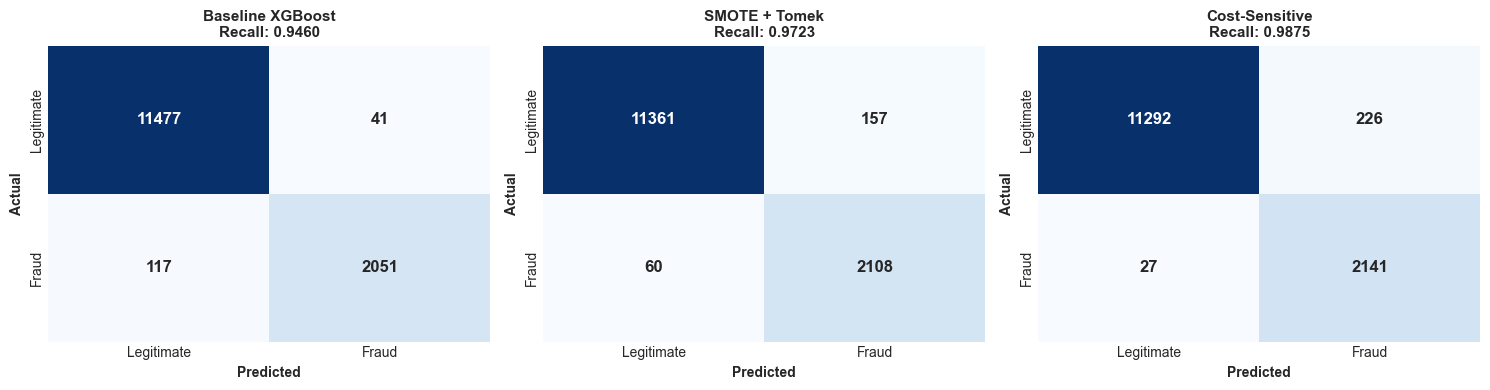

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (model_name, model_results) in enumerate(results.items()):
    cm = model_results['cm']
    ax = axes[idx]
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'],
                ax=ax, cbar=False, annot_kws={'size': 12, 'weight': 'bold'})
    
    ax.set_title(f'{model_name}\nRecall: {model_results["recall"]:.4f}', 
                 fontweight='bold', fontsize=11)
    ax.set_ylabel('Actual', fontweight='bold')
    ax.set_xlabel('Predicted', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/part1_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()